In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00


# Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datasets import load_dataset
import os

# Using Dataset From Datasets Library

In [3]:
dataset = load_dataset("yelp_review_full")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Spliting The Data

In [4]:
train_texts = [x["text"] for x in dataset["train"]]
train_labels = np.array([x["label"] for x in dataset["train"]])
test_texts = [x["text"] for x in dataset["test"]]
test_labels = np.array([x["label"] for x in dataset["test"]])

In [5]:
def categorize_sentiment(label):
    if label in [0, 1]:
        return 0  # Negative
    elif label == 2:
        return 1  # Neutral
    else:
        return 2  # Positive


# Preprocessing the Data

In [6]:
train_labels = np.array([categorize_sentiment(label) for label in train_labels])
test_labels = np.array([categorize_sentiment(label) for label in test_labels])

In [7]:
vocab_size = 20000
max_length = 300
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Downloading GloVe(Preprocessed Embedding)

In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-02-28 11:47:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-28 11:47:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-28 11:47:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Using GloVe

In [9]:
def load_glove_embeddings(glove_path="glove.6B.100d.txt", embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index

In [10]:
embedding_dim = 100
glove_embeddings = load_glove_embeddings()

In [11]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Bidirectional Lstm Model

In [12]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model

In [16]:
history = model.fit(train_padded, train_labels, epochs=15, validation_data=(test_padded, test_labels), batch_size=128, callbacks=[early_stopping])

Epoch 1/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 412s 81ms/step - accuracy: 0.6617 - loss: 0.7784 - val_accuracy: 0.7503 - val_loss: 0.5816
Epoch 2/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 435s 80ms/step - accuracy: 0.7503 - loss: 0.5836 - val_accuracy: 0.7749 - val_loss: 0.5273
Epoch 3/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 451s 82ms/step - accuracy: 0.7756 - loss: 0.5298 - val_accuracy: 0.7905 - val_loss: 0.4927
Epoch 4/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 436s 80ms/step - accuracy: 0.7908 - loss: 0.4941 - val_accuracy: 0.7964 - val_loss: 0.4769
Epoch 5/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 449s 82ms/step - accuracy: 0.7984 - loss: 0.4765 - val_accuracy: 0.8016 - val_loss: 0.4684
Epoch 6/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 442s 82ms/step - accuracy: 0.8062 - loss: 0.4588 - val_accuracy: 0.8074 - val_loss: 0.4555
Epoch 7/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 442s 82ms/step - accuracy: 0.8133 - loss: 0.4455 - val_accuracy: 0.8112 - val_loss: 0.4468
Epoch 8/15
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 415s 82ms/step - accuracy: 

# Test Accuracy

In [17]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.8100 - loss: 0.4553
Test Accuracy: 0.8193


# Ploting for Accuracy and Loss

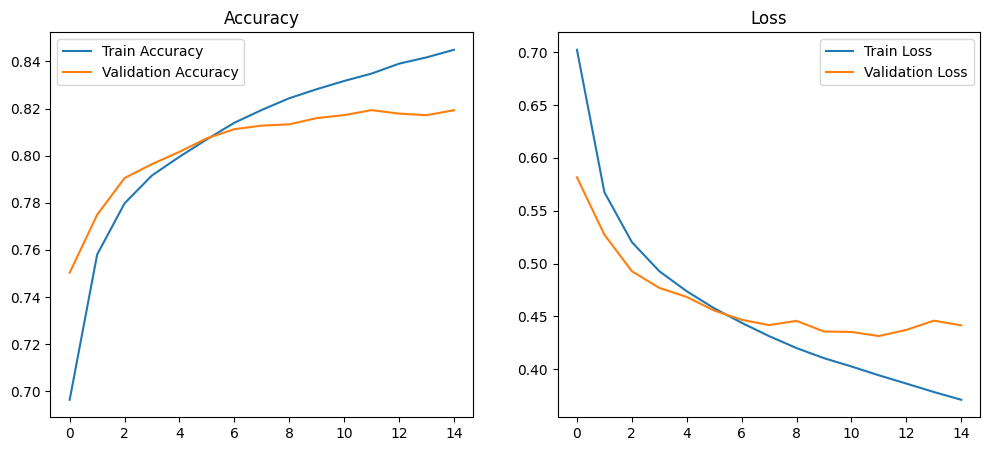

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Function for Prediction

In [19]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    pred = model.predict(padded)
    labels = ['Negative', 'Neutral', 'Positive']
    return labels[np.argmax(pred)]

# Sample Prediction

In [20]:
sample_reviews = [
    "The food was amazing and the service was excellent!",
    "It was okay, not great but not terrible either.",
    "Worst experience ever. I will never come back!"
]

In [21]:
for review in sample_reviews:
    print(f"Review: {review} -> Sentiment: {predict_sentiment(review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Review: The food was amazing and the service was excellent! -> Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Review: It was okay, not great but not terrible either. -> Sentiment: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Review: Worst experience ever. I will never come back! -> Sentiment: Negative


# Saving the model

In [25]:
import pickle
model.save("sentiment_model.h5")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
